# Overview of the CrystFEL-based processing

This notebook comprises a workflow using CrystFEL-based tools combined with original scripts. Below is a step-by-step guide:

1. **Run Indexamajig** (`gandalf_iterator`)  
   - Perform peakfinding, indexing, and integration for each HDF5 file in the specified folder, varying beam center coordinates on a grid withing a given radius.

2. **Evaluate IQM** (`automate_evaluation`)  
   - Parse stream files for indexing quality metrics (IQMs), apply weights, and identify the best results.

3. **Merge** (`merge`)  
   - Merge the best result stream file to refine cell parameters and symmetry.

4. **Convert**  
   - **to `.hkl`** for ShelX (`convert_hkl_crystfel_to_shelx`).  
   - **to `.mtz`** for downstream crystallographic tools (`convert_hkl_to_mtz`).

Please ensure that preprocessing (peak finding, center finding and center refinement) has been done and that you have the required packages and environment set up (CrystFEL, Python packages, etc.) before proceeding.


# Run Indexamajig with options for peakfinding, indexing and integration

In [ ]:
from gandalf_radial_iterator import gandalf_iterator

geomfile_path = "/Users/xiaodong/Desktop/simulations/LTA/LTAsim.geom"       # .geom file
cellfile_path = "/Users/xiaodong/Desktop/simulations/LTA/LTA.cell"          # .cell file

input_path =   "/Users/xiaodong/Desktop/simulations/LTA/simulation-34"      # .h5 folder will also be output folder

output_file_base = "LTA"    # output files will be named output_file_base_xcoord_ycoord.h5

num_threads = 8             # number of CPU threads to use

"""Define the grid and maximum radius for iterations.
As example max_radius = 1, step = 0.2 will give 81 iterations.
Iterations will start at the center and move radially outwards.
"""
max_radius = 2             # maximum radius in pixels
step = 0.5                 # grid granularity in pixels

extra_flags=[
# PEAKFINDING
"--no-revalidate",
"--no-half-pixel-shift",
# "--peaks=cxi", 
# "--min-peaks=15",
"--peaks=peakfinder9",
"--min-snr=1",
"--min-snr-biggest-pix=1",
"--min-sig=10",
"--local-bg-radius=5",
# INDEXING
"--indexing=xgandalf",
"--tolerance=10,10,10,5",
"--no-refine",
"--xgandalf-sampling-pitch=5",
"--xgandalf-grad-desc-iterations=1",
"--xgandalf-tolerance=0.02",
# INTEGRATION
"--integration=rings",
"--int-radius=4,5,9",
"--fix-profile-radius=70000000",
# OUTPUT
"--no-non-hits-in-stream",
]

"""Examples of extra flags(see crystfel documentation https://www.desy.de/~twhite/crystfel/manual-indexamajig.html):
    
    Peakfinding
    "--peaks=cxi",
    "--peak-radius=inner,middle,outer",
    "--min-peaks=n",
    "--median-filter=n",
    "--filter-noise",
    "--no-revalidate",
    "--no-half-pixel-shift",

    "--peaks=peakfinder9",
    "--min-snr=1",
    "--min-snr-peak-pix=6",
    "--min-snr-biggest-pix=1",
    "--min-sig=9",
    "--min-peak-over-neighbour=5",
    "--local-bg-radius=5",

    "--peaks=peakfinder8",
    "--threshold=45",
    "--min-snr=3",
    "--min-pix-count=3",
    "--max-pix-count=500",
    "--local-bg-radius=9",
    "--min-res=30",
    "--max-res=500",
    
    Indexing
    "--indexing=xgandalf",

    "--tolerance=tol"
    "--no-check-cell",
    "--no-check-peaks",
    "--multi",
    "--no-retry",
    "--no-refine",

    "--xgandalf-sampling-pitch=n"
    "--xgandalf-grad-desc-iterations=n"
    "--xgandalf-tolerance=n"
    "--xgandalf-no-deviation-from-provided-cell"
    "--xgandalf-max-lattice-vector-length=n"
    "--xgandalf-min-lattice-vector-length=n"
    "--xgandalf-max-peaks=n"

    Integration
    "--fix-profile-radius=n",
    "--integration=rings",
    "--int-radius=4,5,10",
    "--push-res=n",
    "--overpredict",

    Output
    "--no-non-hits-in-stream",
    "--no-peaks-in-stream",
    "--no-refls-in-stream",
"""

gandalf_iterator(geomfile_path, cellfile_path, input_path, output_file_base, num_threads, max_radius=max_radius, step=step, extra_flags=extra_flags)


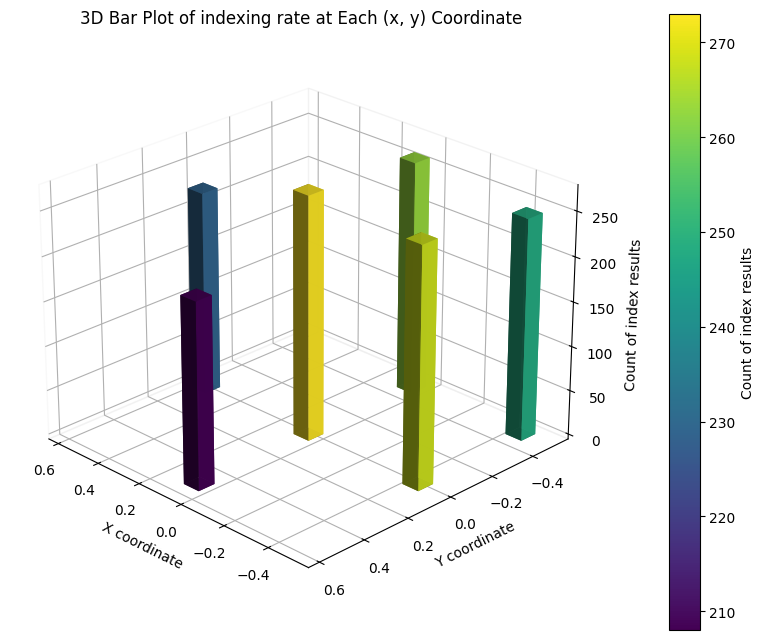

In [1]:
# Visualize indexing results in 3D

from indexing_3d_histogram import plot3d_indexing_rate

plot3d_indexing_rate("/Users/xiaodong/Desktop/simulations/LTA/simulation-34/xgandalf_iterations_max_radius_2_step_0.5")

# Evaluate the IQM with chosen weights for all frames across all index results

In [ ]:
from automate_evaluation import automate_evaluation

# Enter folder with stream file results from indexamajig. 
# Note that ALL stream files in the folder will be processed.

stream_file_folder = "/Users/xiaodong/Desktop/simulations/LTA/simulation-24/xgandalf_iterations_max_radius_1_step_0.2" 

"""
The following metrics will be evaluated for analysis in the next step:

- 'weighted_rmsd'
- 'fraction_outliers'
- 'length_deviation'
- 'angle_deviation'
- 'peak_ratio'
- 'percentage_indexed'

"""

automate_evaluation(stream_file_folder, wrmsd_tolerance=2, indexing_tolerance=2)

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import os

from interactive_iqm_v2 import (
    read_metric_csv,
    select_best_results_by_event,
    get_metric_ranges,
    create_combined_metric,
    filter_rows,
    write_filtered_csv
)

#################################
# 1) PATHS
#################################
CSV_PATH = "/Users/xiaodong/Desktop/simulations/LTA/simulation-24/xgandalf_iterations_max_radius_1_step_0.2/normalized_metrics.csv"
FILTERED_CSV_PATH = os.path.join(os.path.dirname(CSV_PATH), 'filtered_metrics.csv')

#################################
# 2) Read the CSV (group by event)
#################################
grouped_data = read_metric_csv(CSV_PATH, group_by_event=True)

#################################
# 3) If you have multiple rows per event, pick "best" row
#################################
best_rows = select_best_results_by_event(grouped_data, sort_metric='weighted_rmsd')

#################################
# 4) Metrics in your CSV
#################################
metrics_in_order = [
    'weighted_rmsd',
    'fraction_outliers',
    'length_deviation',
    'angle_deviation',
    'peak_ratio',
    'percentage_unindexed'
]

#################################
# 5) Helper: plot separate histograms per metric
#################################
def make_histograms(rows, metrics=None, bins=20):
    if not rows:
        print("No data to plot histograms for.")
        return
    if metrics is None:
        metrics = metrics_in_order
    for m in metrics:
        if any(m in r for r in rows):  # ensure row has that key
            values = [r[m] for r in rows if m in r]
            plt.figure()
            plt.hist(values, bins=bins)
            plt.title(f"Histogram of {m}")
            plt.xlabel(m)
            plt.ylabel("Count")
            plt.show()

#################################
# 6) Create threshold sliders for each original metric
#    so user can filter by "metric <= slider_value"
#################################
ranges_dict = get_metric_ranges(best_rows, metrics=metrics_in_order)
metric_sliders = {}

def create_slider(metric_name, min_val, max_val):
    # We'll do a ≤ filter, so default slider to max => "include all"
    default_val = max_val
    step = (max_val - min_val) / 100.0 if max_val != min_val else 0.01
    
    slider = widgets.FloatSlider(
        value=default_val,
        min=min_val,
        max=max_val,
        step=step,
        description=f"{metric_name} ≤"
    )
    return slider

for metric in metrics_in_order:
    mn, mx = ranges_dict[metric]
    metric_sliders[metric] = create_slider(metric, mn, mx)

#################################
# 7) Text fields for per-metric weights to create a combined metric
#################################
weight_text_fields = {}
for metric in metrics_in_order:
    weight_text_fields[metric] = widgets.FloatText(
        value=0.0,  # default to 0 => skip that metric in combined sum
        description=f"Weight for {metric}",
        style={"description_width": "initial"} 
    )

#################################
# 8) A slider to threshold the combined metric
#################################
combined_metric_slider = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=1.0,
    step=0.01,
    description="combined_metric ≤"
)

#################################
# 9) Button & function to create/update combined metric
#################################
def create_or_update_combined_metric(_):
    """
    Read user-entered weights for each metric, compute 'combined_metric' 
    for best_rows, and update the combined_metric_slider's min/max/value.
    """
    # Gather weights from the text fields
    selected_metrics = []
    weights_list = []
    for m in metrics_in_order:
        w = weight_text_fields[m].value
        selected_metrics.append(m)
        weights_list.append(w)

    # Compute the combined metric
    create_combined_metric(
        rows=best_rows,
        metrics_to_combine=selected_metrics,
        weights=weights_list,
        new_metric_name="combined_metric"
    )

    # Compute new min/max for the combined metric
    combined_vals = [r["combined_metric"] for r in best_rows]
    cmin, cmax = min(combined_vals), max(combined_vals)

    # Safely update the slider so no out-of-range errors
    with combined_metric_slider.hold_trait_notifications():
        current_val = combined_metric_slider.value
        if current_val < cmin or current_val > cmax:
            current_val = cmax  # or cmin, as you prefer

        combined_metric_slider.min = cmin
        combined_metric_slider.max = cmax
        combined_metric_slider.value = current_val

    print("Created/updated 'combined_metric' using user-entered weights.")

create_combined_button = widgets.Button(description="Create Combined Metric")
create_combined_button.on_click(create_or_update_combined_metric)

#################################
# 10) Button to apply thresholds, show histograms, and write CSV
#################################
filter_button = widgets.Button(description="Apply Thresholds & Show Histograms")
output_area = widgets.Output()

def on_filter_clicked(_):
    with output_area:
        output_area.clear_output()

        # Build thresholds from slider values on the original metrics
        thresholds = {m: metric_sliders[m].value for m in metrics_in_order}
        
        # If 'combined_metric' exists, also threshold it
        if "combined_metric" in best_rows[0]:
            thresholds["combined_metric"] = combined_metric_slider.value

        # Filter the best_rows
        filtered = filter_rows(best_rows, thresholds)

        print(f"Filtering... {len(best_rows)} rows -> {len(filtered)} pass thresholds.\n")
        
        if filtered:
            # Show histograms for whichever metrics we used
            make_histograms(filtered, metrics=list(thresholds.keys()))
        else:
            print("No rows passed the thresholds, skipping histograms.")

        # Write a CSV of the filtered rows (including the combined metric, if present)
        if filtered:
            write_filtered_csv(filtered, FILTERED_CSV_PATH)
            print(f"Filtered CSV (including 'combined_metric' if created) written to:\n  {FILTERED_CSV_PATH}")

filter_button.on_click(on_filter_clicked)

#################################
# 11) Display everything
#################################
# We'll show:
#   - text fields for weights
#   - "Create Combined Metric" button
#   - combined_metric threshold slider
#   - per-metric threshold sliders
#   - "Apply Thresholds & Show Histograms" button
#   - output area
all_widgets = (
    list(weight_text_fields.values()) +
    [create_combined_button, combined_metric_slider] +
    list(metric_sliders.values()) +
    [filter_button, output_area]
)
display(*all_widgets)



In [ ]:
import ipywidgets as widgets
from IPython.display import display
import csv_to_stream  # Your script name (csv_to_stream.py)
import os

# 1) Paths:
FILTERED_CSV_PATH = "/Users/xiaodong/Desktop/simulations/LTA/simulation-24/xgandalf_iterations_max_radius_1_step_0.2/filtered_metrics.csv"
OUTPUT_STREAM_PATH = os.path.join(os.path.dirname(FILTERED_CSV_PATH), 'filtered_metrics.stream')

# 2) Button & output area
create_stream_button = widgets.Button(description="Create Stream from CSV")
output_area = widgets.Output()

def on_create_stream_clicked(_):
    with output_area:
        output_area.clear_output()
        # Call our function from csv_to_stream.py
        csv_to_stream.write_stream_from_filtered_csv(
            filtered_csv_path=FILTERED_CSV_PATH,
            output_stream_path=OUTPUT_STREAM_PATH,
            event_col="event_number",    # or whatever column name your CSV uses
            streamfile_col="stream_file" # or the CSV column that points to the .stream path
        )

create_stream_button.on_click(on_create_stream_clicked)

# 3) Display the button and output
display(create_stream_button, output_area)


# Merge the best results stream file

In [ ]:
from merge import merge

stream_file = "/Users/xiaodong/Desktop/simulations/LTA/simulation-24/xgandalf_iterations_max_radius_1_step_0.2/filtered_metrics copy 2.stream"
pointgroup = "m-3m"
num_threads = 24
iterations = 5

output_dir = merge(
    stream_file,
    pointgroup=pointgroup,
    num_threads=num_threads,
    iterations=iterations,
)

if output_dir is not None:
    print("Merging done. Results are in:", output_dir)

# Convert to shelx compatible .hkl

In [ ]:
from convert_hkl_crystfel_to_shelx import convert_hkl_crystfel_to_shelx 
output_dir = "/Users/xiaodong/Desktop/simulations/LTA/simulation-24/xgandalf_iterations_max_radius_1_step_0.2/merged_IQM_1_1_1_1_1_1_merge_5_iter"
convert_hkl_crystfel_to_shelx(output_dir)

# Convert to mtz

In [ ]:
from convert_hkl_to_mtz import convert_hkl_to_mtz
cellfile_path = "/Users/xiaodong/Desktop/simulations/LTA/LTA.cell"  # If defined above comment out this line
convert_hkl_to_mtz(output_dir, cellfile_path=cellfile_path)